# Modelling Background Data
This notebook attempts to use some basic functions and fitting algorithms to have an analytical function to describe the LHCb background data.

## Setup & Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import Data, Cut, Plots, Consts

In [10]:
SFNAME, SSUFFIX = Consts().get_simulated_tuple()
RFNAME, RSUFFIX = Consts().get_real_tuple()
sd, rd = Data(SFNAME, SSUFFIX), Data(RFNAME, RSUFFIX)
sdc, rdc = Cut(sd), Cut(rd)

## Setup Plotting Functions
Plotting is a pain I just make some simple functions here so that the plots are all consistent and I do not have to repeat code what feels like 500 times.

In [76]:
def simple_hist(invariant_masses, label="Empty label", normalised=True, bins=100, figsize=(11, 9), savefig=None):
    # Create bins evenly spaced bins over the range of invariant_masses provided
    bin_space = np.linspace(int(np.round(np.min(invariant_masses), 0)), int(np.round(np.max(invariant_masses), 1)), bins+1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    hist_data = ax.hist(invariant_masses, bins=bin_space, density=normalised, edgecolor='k', label=label)
    ax.set_ylabel(f'Frequency, normalised = {normalised}')
    ax.set_xlabel('Invariant mass (MeV)')
    plt.legend(frameon=False)
    plt.title('Histogram of Invariant Mass')
    plt.show()
    if savefig is not None:
        plt.savefig(savefig)
    return hist_data

def hist_with_errors(invariant_masses, label="Empty Label", normalised=True, bins=100, bin_space=None, figsize=(11,9), savefig=None, zoom=None):
    if bin_space is None:
        bin_space = np.linspace(int(np.round(np.min(invariant_masses), 0)), int(np.round(np.max(invariant_masses), 1)), bins+1)
    bin_centr = [(bin_space[i] + bin_space[i+1])/2 for i in range(len(bin_space) - 1)]
    bin_width = (bin_space[1] - bin_space[0])
    hist_frq_no_norm = np.histogram(invariant_masses, bin_space, density=False)
    hist_frq = np.histogram(invariant_masses, bin_space, density=normalised) # Get the normalisation factor from this
    hist_err = np.sqrt(hist_frq_no_norm[0]) # Error on the bin is proportional to the sqrt of the counts
    if normalised: # Adjust error bars to be smaller
        hist_err *= (hist_frq[0]/hist_frq_no_norm[0])
        # This will reduce the error by the normalisation factor
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar(bin_centr, hist_frq[0], yerr=hist_err, width=bin_width, edgecolor='k', label=label)
    if zoom is not None:
        ax.set_xlim(zoom[0], zoom[1])
    ax.set_ylabel(f'Frequency (Normalised={normalised})')
    ax.set_xlabel('Invariant Mass (MeV)')
    plt.title('Histogram of Invariant Mass')
    plt.legend(frameon=False)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return hist_frq[0], hist_err, bin_space, bin_centr

def bar_with_funcs():
    pass

## Fetch Data & Pre-Analyse

In [70]:
df = rd.fetch_features(['Lb_M'])

/tmp/ipykernel_2281301/3600458242.py:24: RuntimeWarning: invalid value encountered in true_divide
  hist_err *= (hist_frq[0]/hist_frq_no_norm[0])


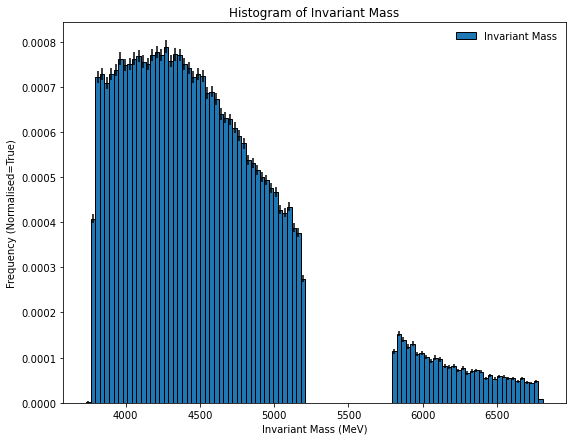

In [71]:
dat = hist_with_errors(df, label='Invariant Mass', figsize=(9, 7), normalised=True)

Apply a basic masscut to remove the rubbish data at the extremes which for now we arbitraruly define as our region of interest $\pm800$ MeV.

In [72]:
pm = 800
cdf = df[df['Lb_M'].between(5250-pm, 5750+pm)]

/tmp/ipykernel_2281301/3673293980.py:24: RuntimeWarning: invalid value encountered in true_divide
  hist_err *= (hist_frq[0]/hist_frq_no_norm[0])


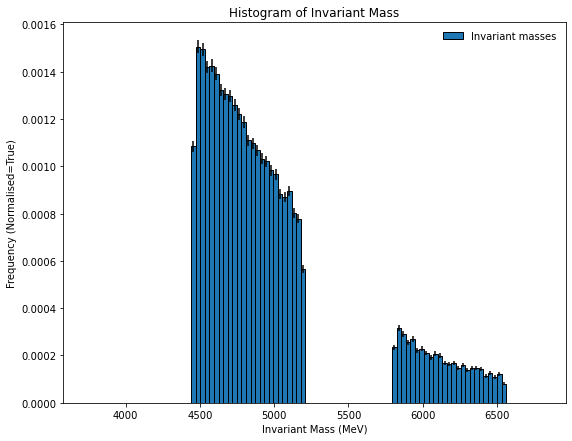

In [77]:
first_cut_hist = hist_with_errors(cdf, label='Invariant masses', bin_space=dat[2], figsize=(9,7))

## Rejigging The Plot
Now we have cut the extremes of the data (which is not well reproduced by the simulation) we can try and fit a function to just this data and see how it fairs. We will use a variety of fitting algorithms starting with the simplest, the least-squares fitting routine. We also will zoom-in on the area of interest whilst using the same bin space.

In [78]:
# Find the start and ends of the bins where there is actually data so we can set an appropriate x-lim
first_non_zero = (first_cut_hist[0] != 0).argmax(axis=0) - 1 
# Apply a mask where all zeros are False and rest is true
last_non_zero = first_cut_hist[0].shape[0] - (np.flip((first_cut_hist[0]!=0)).argmax(axis=0) - 1)
# Reverse the array, find the first occurence and subtract from the length of the array
lower_plot_lim, upper_plot_lim = first_cut_hist[2][first_non_zero], first_cut_hist[2][last_non_zero]
# The actual energies are the indices from the bin-space, given by b[2]

/tmp/ipykernel_2281301/3673293980.py:24: RuntimeWarning: invalid value encountered in true_divide
  hist_err *= (hist_frq[0]/hist_frq_no_norm[0])


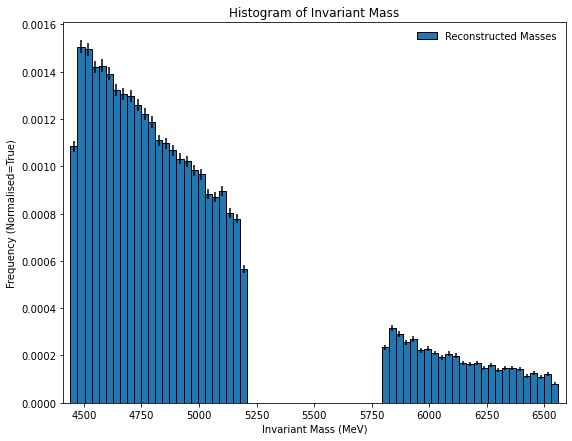

In [79]:
first_cut_hist = hist_with_errors(cdf, label='Reconstructed Masses', bin_space=dat[2], zoom=(lower_plot_lim, upper_plot_lim), figsize=(9, 7))

Prepare these data for being fit to by removing all the zero bins and associated errors etc across all the arrays.

In [97]:
# Combine frequencies, bin centroids and errors into one big array to make removing empty bins easier!
bin_width = first_cut_hist[2][1] - first_cut_hist[2][0]
data = np.array([first_cut_hist[0], first_cut_hist[1], first_cut_hist[3]]).T
# Data is made of 3 columns the frequencies, errors and then the bin centroid, remove all ros with freq=0
data = np.squeeze(data[np.where(data[:,0] != 0),:]) # Find all rows where the first column is not zero and keeps them
# Using numpy.squeeze as other shape returned is (50, 3, 1), removes the redundant axis

## Define Functions
Now we define some functions that we will attempt to fit to these data using a range of fitting routines starting with a least-squares.

In [ ]:
def exponential():
    pass

def gaussian():
    pass

def power():
    pass

In [ ]:
# Now we fit the above
from scipy.optimize import curve_fit